In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
import scipy.stats
import time

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

np.random.seed(1942)

# Regression Class

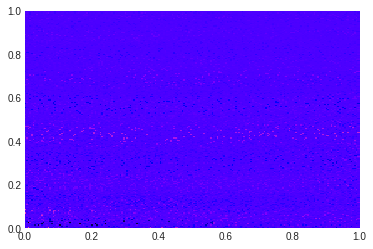

In [66]:
class Regression:
    def __init__(self):
        pass

    def generate_generic_data(self, x, y, func):
        x_mesh, y_mesh = np.meshgrid(x, y)
        x_flat, y_flat = x_mesh.flatten(), y_mesh.flatten()
        self.set_data(x_flat, y_flat, func(x_mesh, y_mesh).flatten())

    def set_data(self, x_flat, y_flat, f_flat):
        self.nr_datapoints = len(x_flat)
        self.x_flat, self.y_flat = x_flat, y_flat
        self.f_flat = f_flat

    def get_X(self, x, y, poly_order):
        self.poly_order = poly_order
        nr_terms = ((poly_order + 1)*(poly_order + 2))//2
        X = np.zeros((np.size(x), nr_terms))
        X[:,0] = 1

        i = 0
        for ix in range(poly_order+1):
            for iy in range(poly_order+1):
                if 0 < ix + iy < poly_order+1:
                    i += 1
                    X[:,i] = x**ix*y**iy
        return X

    def apply_model(self, beta, x, y, poly_order):
        i = 0
        result = beta[0]
        for ix in range(poly_order+1):
            for iy in range(poly_order+1):
                if 0 < ix + iy < poly_order+1:
                    i += 1
                    result += beta[i]*x**ix*y**iy
        return result

    def solveKFold(self, K=5, solver="OLS", poly_order=5):
        x_flat, y_flat, f_flat = self.x_flat, self.y_flat, self.f_flat
        output_pred = np.zeros(self.nr_datapoints)
        kf = KFold_iterator(nr_datapoints, K)
        for train_index, test_index in kf:
            x_train, x_test, y_train, y_test = x_flat[train_index], x_flat[test_index], y_flat[train_index], y_flat[test_index]
            output_train, output_test = f_flat[train_index], f_flat[test_index]
            X = self.get_X(x_train, y_train, poly_order)
            beta = self.get_beta(X, output_train)
            output_test_pred = self.apply_model(beta, x_test, y_test, poly_order)
            output_pred[test_index] = output_test_pred
        output_pred_stacked = np.zeros((nr_points_per_dim, nr_points_per_dim))
        for i in range(nr_points_per_dim):
            output_pred_stacked[i] = output_pred[i*nr_points_per_dim : (i+1)*nr_points_per_dim]
        return output_pred_stacked

    def get_beta(self, X, f, lamda=0, solver="OLS"):
        XT = X.T
        if solver=="OLS":
            beta = np.linalg.inv(XT@X)@XT@f
        elif solver=="Ridge":
            beta = np.linalg.inv(XT@X + np.identity(X.shape[1])*lamda)@XT@f
        elif solver=="Lasso":
            print("TBA")
        else:
            print("Dust")
            raise NotImplementedError
        return beta



nr_points_per_dim = 201
nr_datapoints = nr_points_per_dim**2
reg = Regression()
reg.generate_generic_data(np.linspace(0, 1, nr_points_per_dim), np.linspace(0, 1, nr_points_per_dim), FrankeNoise)
#reg.make_X(poly_order=5)
data_pred = reg.solveKFold(K=20, poly_order=20)
#MSE(data_pred, reg.f_flat)
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, nr_points_per_dim), np.linspace(0, 1, nr_points_per_dim))
plt.pcolormesh(x_mesh, y_mesh, data_pred)
#data_pred = reg.model(reg.beta, reg.x_flat, reg.y_flat)
#MSE(data_pred, reg.f_flat)

# 1. Linear Regression on Generic Data

## 1.1 The Franke Funtion, with noise

In [22]:
def Franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeNoise(x, y, sigma=1):
    return Franke(x, y) + np.random.normal(0, sigma, np.shape(x))

In [23]:
nr_points_per_dim = 201
nr_datapoints = nr_points_per_dim**2

### 1.1.1 Plotting the Franke Function, with and without noise

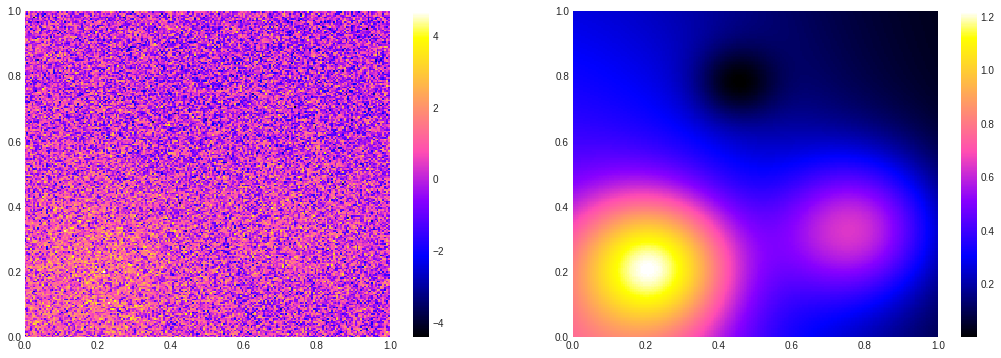

In [24]:
x = np.linspace(0, 1, nr_points_per_dim)
y = np.linspace(0, 1, nr_points_per_dim)
#x = np.random.uniform(0, 1, nr_points_per_dim)
#y = np.random.uniform(0, 1, nr_points_per_dim)
x_, y_ = np.meshgrid(x, y)

x_flat = x_.flatten()
y_flat = y_.flatten()

data = FrankeNoise(x_, y_)
f = data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt1 = ax1.pcolormesh(x_, y_, FrankeNoise(x_,y_));
fig.colorbar(plt1, ax=ax1);

plt2 = ax2.pcolormesh(x_, y_, Franke(x_, y_))
fig.colorbar(plt2, ax=ax2);

## 1.2 Setting up the design matrix and model

In [25]:
poly_order = 5

### 1.2.1 The design matrix, X

In [26]:
def make_X(x_flat, y_flat, poly_order):
    nr_terms = ((poly_order + 1)*(poly_order + 2))//2
    X = np.zeros((np.size(x_flat), nr_terms))
    X[:,0] = 1

    i = 0
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                X[:,i] = x_flat**ix*y_flat**iy
    return X

### 1.2.2 The Model

In [27]:
def Model(beta, x, y, poly_order):
    i = 0
    result = beta[0]
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                result += beta[i]*x**ix*y**iy
    return result

## 1.3 Predicting model from noisy data with Linear Regression using OLS

In [28]:
X = make_X(x_flat, y_flat, poly_order)
beta = np.linalg.inv(X.T@X)@X.T@f
data_pred = Model(beta, x_, y_, poly_order)

## 1.4 Results

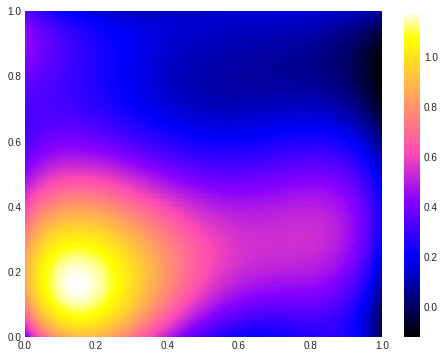

In [29]:
plt.figure(figsize=(8,6))
plt.pcolormesh(x_, y_, data_pred)
plt.colorbar();

## 1.4.1 Score values

In [30]:
print("MSE Score = ", MSE(data, data_pred))
print("RRMSE Score = ", np.sqrt(MSE(data, data_pred))/np.mean(data))
print("MSE Score (vs true model) =", MSE(Franke(x_, y_), data_pred))

MSE Score =  0.9925217691159108
RRMSE Score =  2.4204959174232883
MSE Score (vs true model) = 0.002570313834697993


In [31]:
print("R2 Score = ", r2_score(data, data_pred))

R2 Score =  0.04989589858431113


## 1.4.2 Analysing the noise

In [32]:
noise_pred = data - data_pred

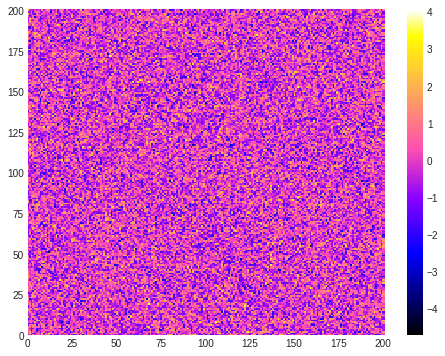

In [33]:
plt.figure(figsize = (8, 6))
plt.pcolormesh(noise_pred)
plt.colorbar();

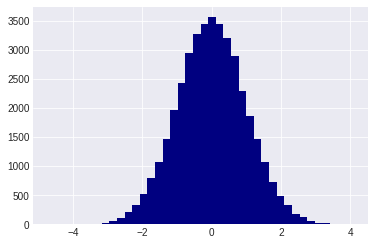

In [34]:
plt.hist(noise_pred.flatten(), bins=40, color="navy");

### 1.4.3 Probability Plot - Confirming normal distribution of noise

0.9999696915240399

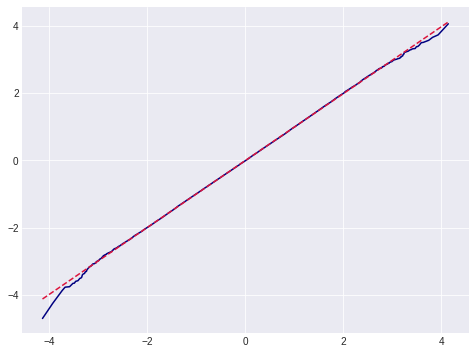

In [35]:
(x, y), (slope, intercept, r) = scipy.stats.probplot(noise_pred.flatten());

plt.figure(figsize = (8,6))
plt.plot(x, y, color="navy");
plt.plot(x, intercept + x*slope, ls="--", c="crimson")
r

## 1.5 Round 2 - Running the model for different polynomial degrees

0.0025539398193359375
0.0036323070526123047
0.01321268081665039
0.031349897384643555
0.052782297134399414
0.11763215065002441
0.10563087463378906
0.16278409957885742
0.18157672882080078
0.2449321746826172
0.27620553970336914
0.3088672161102295
0.34371018409729004
0.4646477699279785
0.48888492584228516
0.5593328475952148


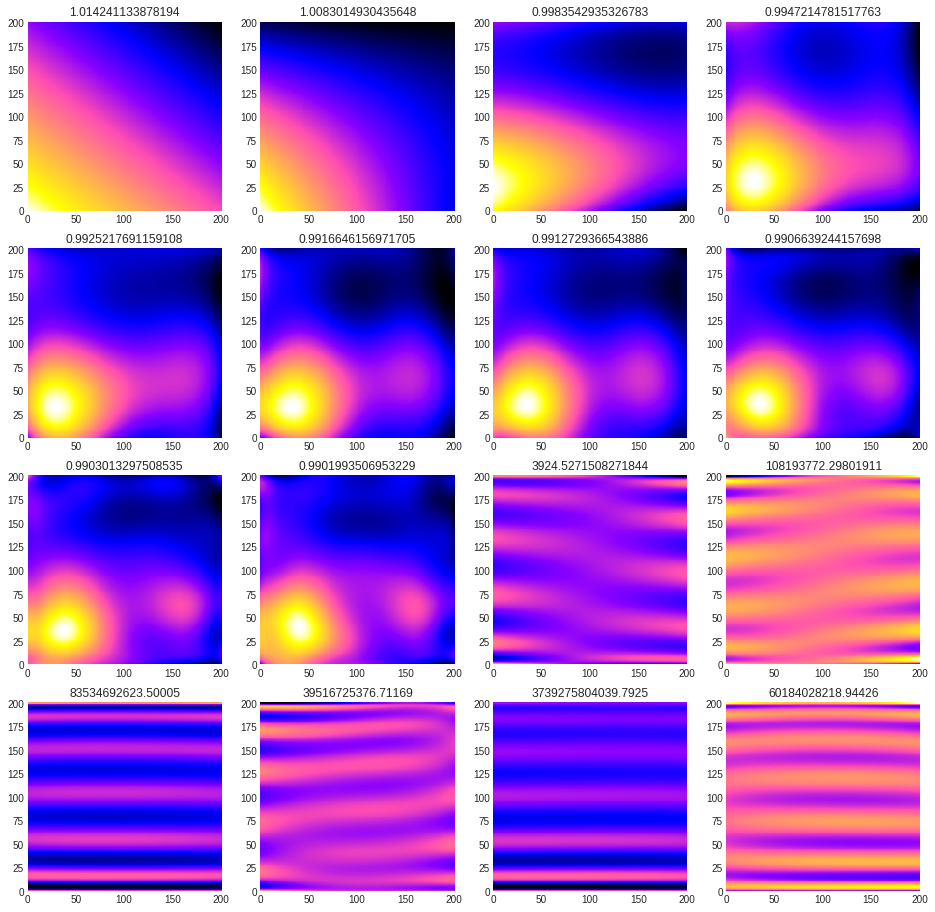

In [36]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

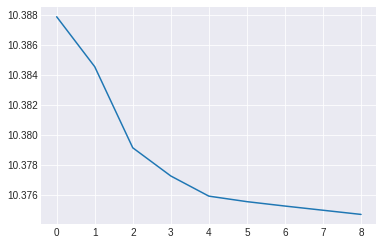

In [37]:
plt.plot(np.log(err_list[:9]));

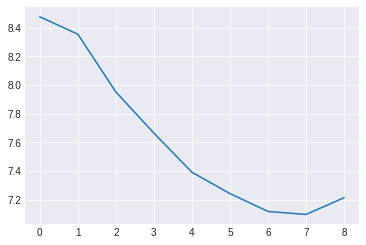

In [38]:
plt.plot(np.log(err_list_truemodel[:9]));

# 2 Ridge Regression

0.0025489330291748047
0.00450444221496582
0.01296234130859375
0.03220629692077637
0.09359574317932129
0.08947134017944336
0.1148672103881836
0.15134716033935547
0.1905057430267334
0.20503640174865723
0.22523164749145508
0.26865625381469727
0.3487129211425781
0.3721482753753662
0.4172172546386719
0.512460470199585
0.5475411415100098
0.6092128753662109
0.6794133186340332
0.7610597610473633
0.8393509387969971
0.8665566444396973
0.9467043876647949
1.0344383716583252
1.1156165599822998
1.2373976707458496
1.352968692779541
1.4667699337005615
1.610107421875
1.7607057094573975
1.916053295135498
1.9842922687530518
2.138327121734619
2.3310625553131104
2.5050439834594727
2.6452856063842773
2.8345413208007812
2.990103006362915
3.1955134868621826
3.382566452026367


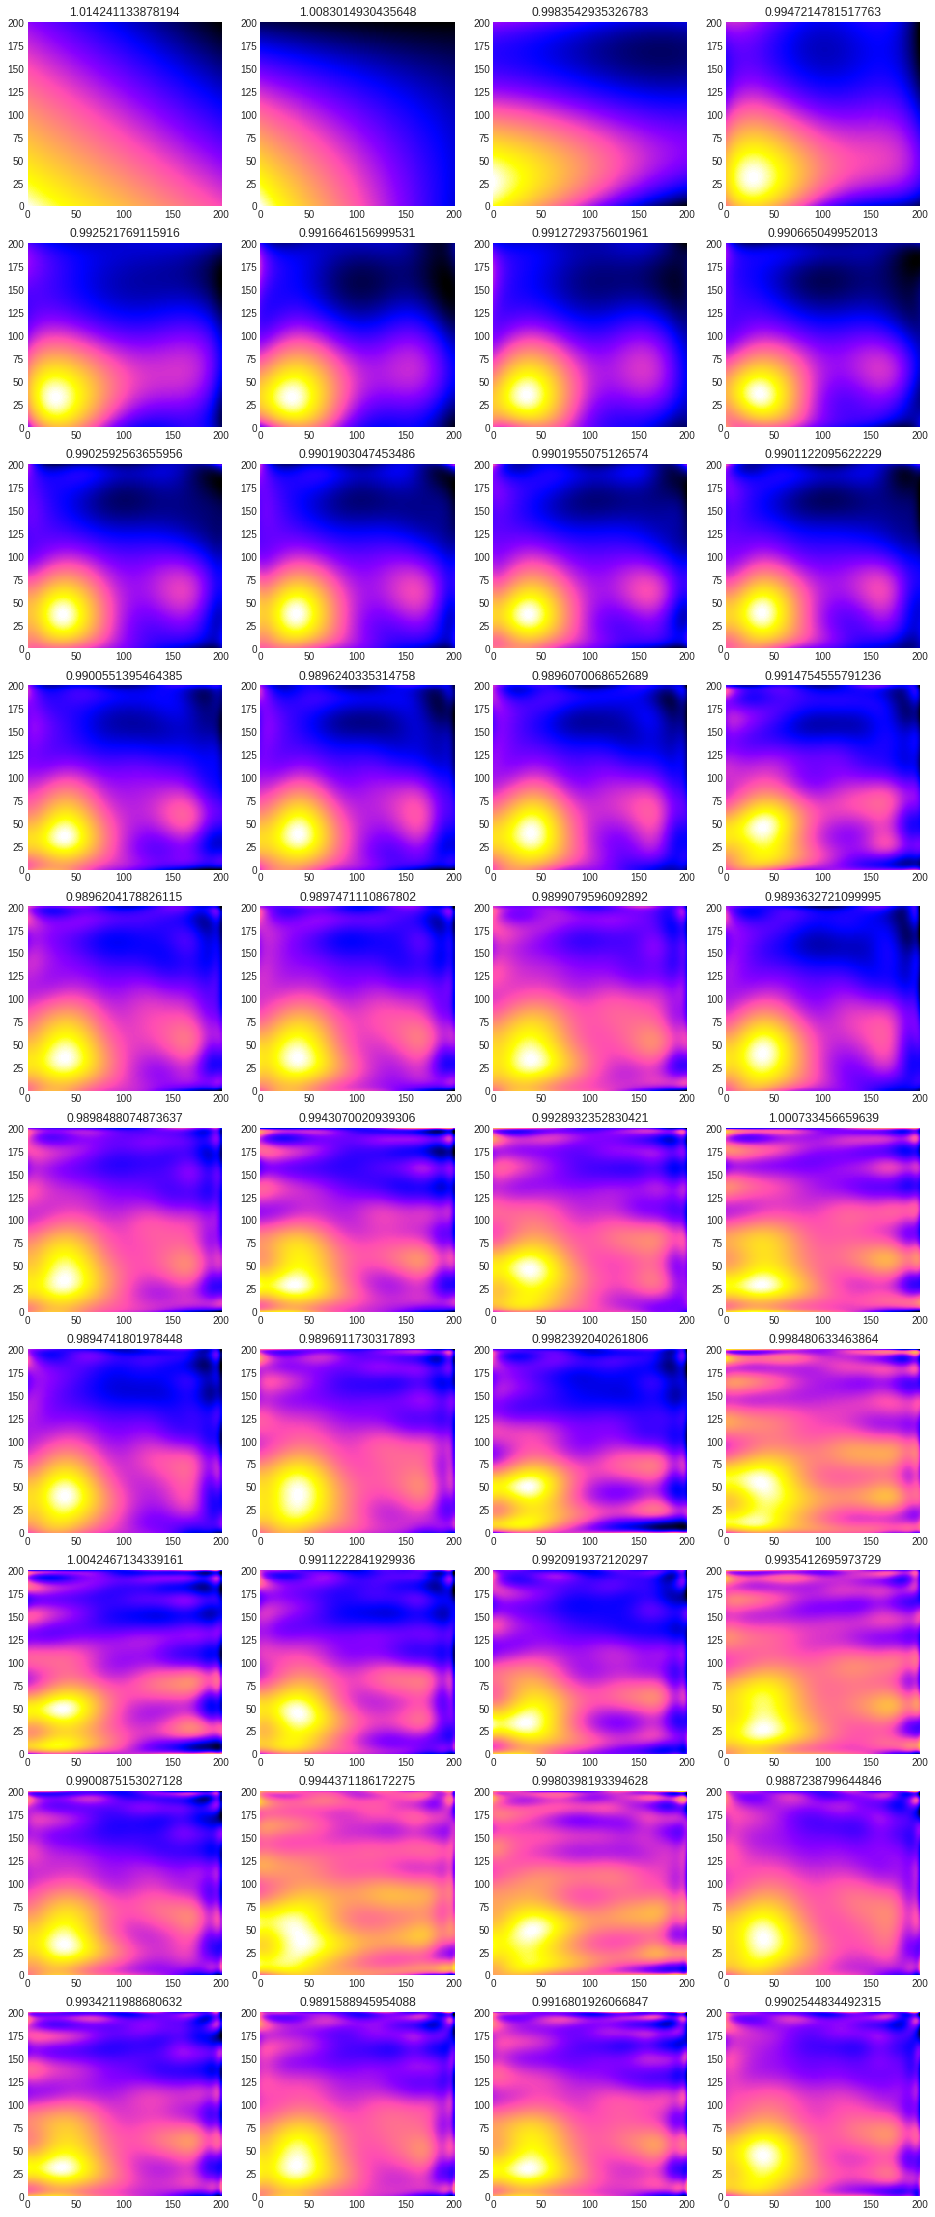

In [39]:
lamda = 1e-8

err_list = []
err_list_truemodel = []
nr_poly_orders = 40
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X + np.identity(X.shape[1])*lamda)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

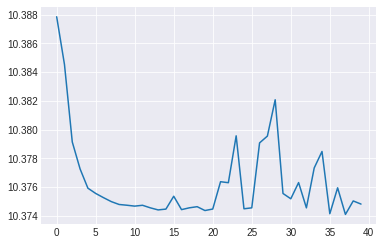

In [40]:
plt.plot(np.log(err_list));

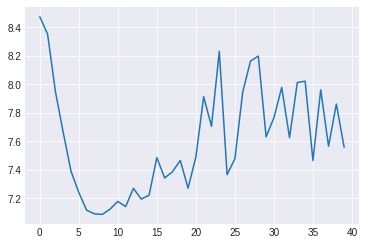

In [41]:
plt.plot(np.log(err_list_truemodel));

# 3. Train-test split

In [42]:
poly_order = 5

input_ = np.zeros((nr_datapoints, 2))
input_[:,0] = x_flat
input_[:,1] = y_flat

In [43]:
input_train, input_test, output_train, output_test = train_test_split(input_, f, test_size = 0.3)

In [44]:
X = make_X(input_train[:,0], input_train[:,1], poly_order)
beta = np.linalg.inv(X.T@X)@X.T@output_train

output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)

In [45]:
MSE(output_test, output_test_pred)

1.0029775341487446

# 4. K-fold validation

In [46]:
class KFold_iterator:
    def __init__(self, input_dim, nr_splits=5):
        self.input_dim = input_dim
        self.nr_splits = nr_splits
        self.nr_iters_done = 0
        self.index_data = self.shuffle_split()

    def __iter__(self):
        return self

    def __next__(self):
        if self.nr_iters_done < self.nr_splits:
            self.iter = (np.concatenate(self.index_data[1:]), self.index_data[0])
            self.index_data = self.index_data[1:] + [self.index_data[0]]
            self.nr_iters_done += 1
            return self.iter
        else:
            raise StopIteration

    def shuffle_split(self):
        indexes = np.arange(self.input_dim)
        np.random.shuffle(indexes)
        return np.array_split(indexes, self.nr_splits)

In [47]:
def K_fold_validation(input_, output, K=5):
    output_pred = np.zeros(nr_datapoints)
    #kf = KFold(n_splits = K, shuffle=True)
    kf = KFold_iterator(nr_datapoints, K)
    for train_index, test_index in kf:
        input_train, input_test = input_[train_index], input_[test_index]
        output_train, output_test = output[train_index], output[test_index]
        X = make_X(input_train[:,0], input_train[:,1], poly_order)
        beta = np.linalg.inv(X.T@X)@X.T@output_train

        output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)
        output_pred[test_index] = output_test_pred
    return output_pred

In [48]:
output_pred = K_fold_validation(input_, f)

In [49]:
MSE(output_pred, f)

0.9938277884726199